In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  3 22:05:32 2020
@author: 孙文约
"""

#导入包
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats


## Chapter 1 数据的采集，清理与处理

In [7]:
### 1.1 数据集th_video_data.csv
#th_video_data.csv来自国地东 苏南/上海-氘化氢(1159841057) 的爬虫
#其包含了东方视频的相关数据   

path_video = r'C:\Users\dell\Desktop\thkp\th_video_data.csv'
data_origin_video = pd.read_csv(path_video)
data_origin_video.columns = ['av号',
                       '发布时间（1970.1.1以来的秒数）',
                       'up_mid',
                       'up_name',
                       '点击','弹幕',
                       '回复','收藏',
                       '硬币']

#缺失数据的处理
#因为初始数据全为0时，表示数据状态异常
#此时用up_mid代替
data_miss_video = data_origin_video.loc[data_origin_video['up_mid']==0]
data_video      = data_origin_video.drop(index=data_miss_video.index)

###1.2 数据集th_video_tags
#th_video_data.csv来自国地东 苏南/上海-氘化氢(1159841057) 的爬虫
#其包含的东方视频的av号信息以及tag的相关数据
path_tag = r'C:\Users\dell\Desktop\thkp\th_video_tags_200208.csv'
data_origin_tag = pd.read_csv(path_tag)

###1.3 数据集th_ups

## Chapter 2 Up主数量与投稿数量的分析
下面开始进行数据分析的环节。
目前我们存在着现存的av号码，以及创作者的和作品的相关数据。
首先我们对于作者的创作周期进行分析,
探究创作者的分布情形

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys


Text(0.5, 1.0, 'up主人数与创作量的关系')

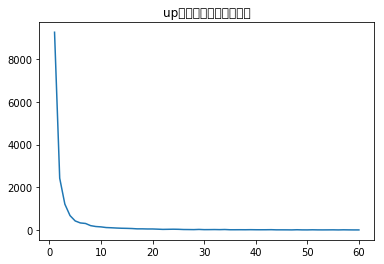

In [28]:
up_list = data_video[['av号','up_mid','up_name']]
up_list = up_list.set_index(['up_mid','up_name'])

#每个创作数统计
up_product = up_list.count(level='up_mid')
up_product.columns = ['video_quantity']
up_product = up_product.sort_index(by=['video_quantity'],ascending=False)
up_product.index   = range(1,len(up_product)+1)

up_list = data_video[['up_mid','up_name']]

#老艾：这一部分的图片可不可以用svg
#此处建议采用区间分类方法，或者对数估计法
#投稿数的set
production_num = []
for i in range(0,len(up_product)):
    production_num.append(up_product.values[i][0])
production_list = list(set(production_num))
production_list.sort()

#同一投稿数下的up人数数量(对数化)
production_num_up = [] 
for i in production_list:
    production_num_up.append(
            len(up_product[up_product['video_quantity']==i])
            )

df_up_production = pd.DataFrame([
        production_list,
        production_num_up
        ]).T
    

df_up_production.columns = ['video_quantity','up_quantity']
df_up_production.index   = df_up_production['video_quantity']
df_up_production = df_up_production['up_quantity']

#est_powerlaw =  stats.powerlaw.

plt.plot(df_up_production.head(60))
plt.title('up主人数与创作量的关系')




C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


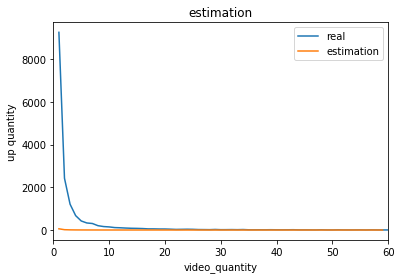

对于前60的数据进行拟合分析，我们有：
协变量为：-1.8909389745208764
截距为：4.031892701770063
lny = 4.031892701770063+ lnx * -1.8909389745208764
R square is 0.9786115236910257


In [44]:
import scipy
head_num = 60 #这里可以留着作为待调整参数之一
from sklearn import linear_model
regr = linear_model.LinearRegression()
res = regr.fit(
        np.log10(np.array(production_list[:head_num]).reshape(-1,1)),
        np.log10(np.array(production_num_up[:head_num]).reshape(-1,1))
                                   )
score = res.score(
        np.log10(np.array(production_list[:head_num]).reshape(-1,1)),
        np.log10(np.array(production_num_up[:head_num]).reshape(-1,1)))

x = range(0,head_num)
y = (x**res.coef_[0][0])*(scipy.e**res.intercept_[0])
plt.title('estimation')
plt.plot(df_up_production[:head_num],label='real')
plt.xlabel('video_quantity')
plt.ylabel('up quantity')
plt.xlim(0,60.0)
plt.plot(x,y,label='estimation')
plt.legend(loc='top right')
plt.show()

print('对于前' + str(head_num) +'的数据进行拟合分析，我们有：')
print('协变量为：'+ str(res.coef_[0][0]))
print('截距为：'+ str(res.intercept_[0]))
print('lny = '+ str(res.intercept_[0]) + 
      '+ lnx * ' + str(res.coef_[0][0]))   
print('R square is ' + str(score))


##  Chapter3
我们如何对于up主进行分类。
所以此时我们另外需要b站up主的数据集合

对于up主来讲，我们还可以统计出哪些数据进行分类？

1. up主的初次投稿开始时间，最后一次投稿的结束时间
2. up主的投稿数量以及收藏等数据...但是收藏等数据有一个问题，随着投稿的数量质量不同会有差异，因此可以采用收藏/投币/点赞所的中位数/最大值/平均值
3. up主的投稿tag会影响up主的关键词，但是另外一部分关键词并不是体现在up主的关键词而是在于弹幕当中
4. up主随着时间的改变影响了风格，那么会如何看待
如果一个up主的粉丝很多，那么究竟是单次的高产导致还是因为不断的投稿，或者是因为up主本身就具有很多的流量，导致了其他的粉丝向b站潜移？
如何在数据上进行辨别？


-8031.74292626183


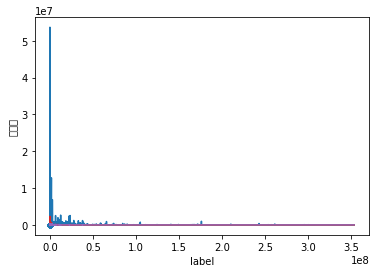

In [45]:
#up主数据汇总,先做一个无监督学习
up_video = data_video.groupby(['up_mid']).sum()
up_video.sort_index(level=1)
up_video = up_video[['点击','弹幕','回复','收藏','硬币']]
up_video.columns = ['总点击','总弹幕','总回复','总收藏','总硬币']

up_production = data_video.groupby(['up_mid']).count()[['av号','up_name']]

up_data = pd.merge(up_list,up_video,on='up_mid')
up_data = pd.merge(up_data,up_production,on='up_mid')
up_data.index = up_data['up_mid']
up_data = up_data.sort_index(level=1).drop_duplicates()
up_data = up_data[['up_name_x','总点击','总弹幕','总回复','总收藏','总硬币','up_name_y']]
up_data.columns = ['up_name','总点击','总弹幕','总回复','总收藏','总硬币','投稿数']

#下面进行聚类分析

group_num = 6
from sklearn.cluster import KMeans
UL_data = up_data[['总点击',
                   '总弹幕',
                   '总回复',
                   '总收藏',
                   '总硬币',
                      ]]
#标准化z-score
UL_data = (UL_data - UL_data.mean(axis=0))/(UL_data.std(axis=0))
#求协方差矩阵
up_cov = UL_data.cov()
#聚类分析，Kmenad拟合
kmodel = KMeans(n_clusters=group_num,n_jobs=3)
k_res = kmodel.fit(UL_data)
print(k_res.score(UL_data))
#讲新的分群纳入到这里面
UL_data['label']=k_res.labels_

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
colors = ['black', 'blue', 'red', 'yellow', 'brown','green']
UL_data.plot.scatter('label',y='总点击',subplots=True)

plt.plot(up_video)

## Chapter4 东方视频的占比数量分布
在这里，我们需要一个bilibili历来的视频数据集
来确定东方在bilibili当中的视频占比究竟如何，
并且给出时间的趋势以及分析
